In [1]:
# CELL 0: KIỂM TRA VÀ SETUP GPU (CHẠY TRƯỚC TIÊN!)

import tensorflow as tf
import sys
from tensorflow.python.platform import build_info as tf_build_info
print(tf_build_info.build_info)
print("="*60)
print("KIỂM TRA GPU")
print("="*60)

# 1. Kiểm tra phiên bản TensorFlow
print(f"\n🔍 TensorFlow version: {tf.__version__}")
print(f"🔍 Python version: {sys.version}")

# 2. Kiểm tra GPU có sẵn không
gpus = tf.config.list_physical_devices('GPU')
print(f"\n🖥️  Số lượng GPU phát hiện: {len(gpus)}")

if len(gpus) > 0:
    print("✅ PHÁT HIỆN GPU!")
    for i, gpu in enumerate(gpus):
        print(f"   GPU {i}: {gpu}")
        # Lấy thông tin chi tiết (nếu có thể)
        try:
            gpu_details = tf.config.experimental.get_device_details(gpu)
            print(f"      Device name: {gpu_details.get('device_name', 'N/A')}")
        except:
            print(f"      (Không lấy được chi tiết)")
    
    # 3. Cấu hình GPU memory growth (QUAN TRỌNG!)
    # Tránh TensorFlow chiếm hết VRAM ngay từ đầu
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("\n✅ Đã bật memory growth (GPU sẽ tăng dần VRAM khi cần)")
    except RuntimeError as e:
        print(f"\n⚠️  Không thể set memory growth: {e}")
    
    # 4. Test thử GPU
    print("\n🧪 Test GPU với phép tính đơn giản...")
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
        b = tf.constant([[5.0, 6.0], [7.0, 8.0]])
        c = tf.matmul(a, b)
    print(f"✅ Kết quả test: {c.numpy()}")
    print("✅ GPU hoạt động tốt!")
    
    # 5. Hiển thị device được TensorFlow sử dụng
    print(f"\n📌 Default device: {tf.test.gpu_device_name()}")
    
else:
    print("❌ KHÔNG PHÁT HIỆN GPU!")
    print("\n🔧 Cách khắc phục:")
    print("   1. Kiểm tra driver NVIDIA đã cài chưa:")
    print("      - Mở CMD, gõ: nvidia-smi")
    print("   2. Cài đúng CUDA Toolkit và cuDNN:")
    print("      - TensorFlow 2.10+: CUDA 11.2, cuDNN 8.1")
    print("      - Xem hướng dẫn: https://www.tensorflow.org/install/gpu")
    print("   3. Reinstall TensorFlow GPU version:")
    print("      - pip uninstall tensorflow")
    print("      - pip install tensorflow[and-cuda]")
    print("\n⚠️  Mô hình sẽ chạy trên CPU (RẤT CHẬM!)")

# 6. Hiển thị tất cả devices
print("\n" + "="*60)
print("TẤT CẢ DEVICES AVAILABLE")
print("="*60)
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
for device in devices:
    print(f"\n📱 Device: {device.name}")
    print(f"   Type: {device.device_type}")
    print(f"   Memory: {device.memory_limit / 1024**3:.2f} GB")

print("\n" + "="*60)
print("✅ KIỂM TRA HOÀN TẤT!")
print("="*60)


OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])
KIỂM TRA GPU

🔍 TensorFlow version: 2.10.0
🔍 Python version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]

🖥️  Số lượng GPU phát hiện: 1
✅ PHÁT HIỆN GPU!
   GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
      Device name: NVIDIA GeForce RTX 3050 Laptop GPU

✅ Đã bật memory growth (GPU sẽ tăng dần VRAM khi cần)

🧪 Test GPU với phép tính đơn giản...
✅ Kết quả test: [[19. 22.]
 [43. 50.]]
✅ GPU ho

In [2]:
# ========================================
# CELL 1: CÀI ĐẶT VÀ IMPORT THƯ VIỆN
# ========================================

"""
Hệ thống phân loại cảm xúc sử dụng BERT
Multi-label Emotion Classification với 12 loại cảm xúc
"""

# Cài đặt các thư viện cần thiết (chạy lần đầu)
%pip install tensorflow tensorflow-hub tensorflow-text pandas scikit-learn matplotlib seaborn

# Import thư viện
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime

# Thiết lập style cho biểu đồ
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Kiểm tra phiên bản và GPU
print("="*60)
print("THÔNG TIN HỆ THỐNG")
print("="*60)
print(f"📦 TensorFlow version: {tf.__version__}")
print(f"📦 Pandas version: {pd.__version__}")
print(f"📦 NumPy version: {np.__version__}")
print(f"🖥️  GPU có sẵn: {len(tf.config.list_physical_devices('GPU')) > 0}")
if len(tf.config.list_physical_devices('GPU')) > 0:
    print(f"   GPU devices: {tf.config.list_physical_devices('GPU')}")
else:
    print("   ⚠️  Không có GPU - Training sẽ chậm hơn")
print("="*60)

# Thiết lập seed cho reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("\n✅ Import thành công!")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


THÔNG TIN HỆ THỐNG
📦 TensorFlow version: 2.10.0
📦 Pandas version: 1.5.3
📦 NumPy version: 1.24.3
🖥️  GPU có sẵn: True
   GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

✅ Import thành công!


In [4]:
# CELL 1: Import thư viện và load dữ liệu
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load dataset
train_data = pd.read_csv('https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/master/nlp_train.csv')
val_data = pd.read_csv('https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/master/nlp_valid.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/master/nlp_test.csv')

print(f"Train: {train_data.shape}, Val: {val_data.shape}, Test: {test_data.shape}")
train_data.head()

Train: (1493, 14), Val: (1493, 14), Test: (374, 14)


,id,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,0,He was answering a question about the criticis...,1,0,1,0,0,0,0,1,0,0,0,0
1,1,I'm going to start today's discussion thread w...,1,1,1,1,0,0,0,1,0,0,0,0
2,2,"By announcing the 395 self-quarantined, it pai...",1,1,1,1,0,0,0,1,0,0,0,0
3,3,"Likewise, sorry if I offended you. I’m not act...",1,0,1,1,0,0,0,1,0,0,0,0
4,4,"People infected by experience high fever, coug...",0,0,0,0,0,0,0,0,0,0,0,1


In [6]:
# CELL 2: Tiền xử lý dữ liệu
train_sentiment_data = train_data.dropna()
train_sentiment_data = train_sentiment_data.reset_index(drop=True)

val_sentiment_data = val_data.dropna()
val_sentiment_data = val_sentiment_data.reset_index(drop=True)

test_sentiment_data = test_data.dropna()
test_sentiment_data = test_sentiment_data.reset_index(drop=True)

label_class = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 
               'optimism', 'pessimism', 'sadness', 'surprise', 'trust', 'neutral']

input_data_train = train_sentiment_data['text'].values
label_data_train = train_sentiment_data[label_class].values

input_data_val = val_sentiment_data['text'].values
label_data_val = val_sentiment_data[label_class].values

input_data_test = test_sentiment_data['text'].values
label_data_test = test_sentiment_data[label_class].values

print("Input train shape: ", input_data_train.shape)
print("Label train shape: ", label_data_train.shape)
print("Input val shape: ", input_data_val.shape)
print("Label val shape: ", label_data_val.shape)
print("Input test shape: ", input_data_test.shape)
print("Label test shape: ", label_data_test.shape)

Input train shape:  (1493,)
Label train shape:  (1493, 12)
Input val shape:  (165,)
Label val shape:  (165, 12)
Input test shape:  (374,)
Label test shape:  (374, 12)


In [8]:
# CELL 3: Xây dựng mô hình BERT
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2', trainable=False, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(400, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(200, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(100, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(50, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(12, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(inputs = text_input, outputs = net)

classifier_model = build_classifier_model()
classifier_model.summary()

adam = tf.keras.optimizers.Adam(learning_rate=0.001)
metric_acc = tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)
classifier_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[metric_acc])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [6]:
# CELL 4: Huấn luyện mô hình
callback_model = tf.keras.callbacks.ModelCheckpoint('model_small_bert.h5', monitor='val_loss')
history = classifier_model.fit(
    x=input_data_train, y = label_data_train,
    epochs=100,
    validation_data = (input_data_val, label_data_val), 
    callbacks=[callback_model]
)

Epoch 1/100
47/47 [==============================] - 18s 225ms/step - loss: 0.5675 - binary_accuracy: 0.6962 - val_loss: 0.5312 - val_binary_accuracy: 0.7091
Epoch 2/100
47/47 [==============================] - 16s 342ms/step - loss: 0.5356 - binary_accuracy: 0.7189 - val_loss: 0.5121 - val_binary_accuracy: 0.7389
Epoch 3/100
47/47 [==============================] - 13s 283ms/step - loss: 0.5202 - binary_accuracy: 0.7346 - val_loss: 0.5026 - val_binary_accuracy: 0.7384
Epoch 4/100
47/47 [==============================] - 13s 282ms/step - loss: 0.5122 - binary_accuracy: 0.7437 - val_loss: 0.4951 - val_binary_accuracy: 0.7591
Epoch 5/100
47/47 [==============================] - 13s 284ms/step - loss: 0.5075 - binary_accuracy: 0.7465 - val_loss: 0.4812 - val_binary_accuracy: 0.7626
Epoch 6/100
47/47 [==============================] - 13s 282ms/step - loss: 0.4992 - binary_accuracy: 0.7499 - val_loss: 0.4886 - val_binary_accuracy: 0.7520
Epoch 7/100
47/47 [==============================] -

12/12 [==============================] - 4s 278ms/step
              precision    recall  f1-score   support

       anger       0.45      0.49      0.47       121
anticipation       0.70      0.53      0.60       218
     disgust       0.61      0.68      0.64       156
        fear       0.66      0.52      0.58       195
         joy       0.50      0.11      0.19        70
        love       0.31      0.17      0.22        30
    optimism       0.42      0.39      0.40        97
   pessimism       0.43      0.58      0.50       120
     sadness       0.51      0.26      0.34       136
    surprise       0.20      0.10      0.14        49
       trust       0.27      0.20      0.23        60
     neutral       0.28      0.29      0.29        38

   micro avg       0.52      0.44      0.48      1290
   macro avg       0.45      0.36      0.38      1290
weighted avg       0.52      0.44      0.46      1290
 samples avg       0.46      0.42      0.40      1290



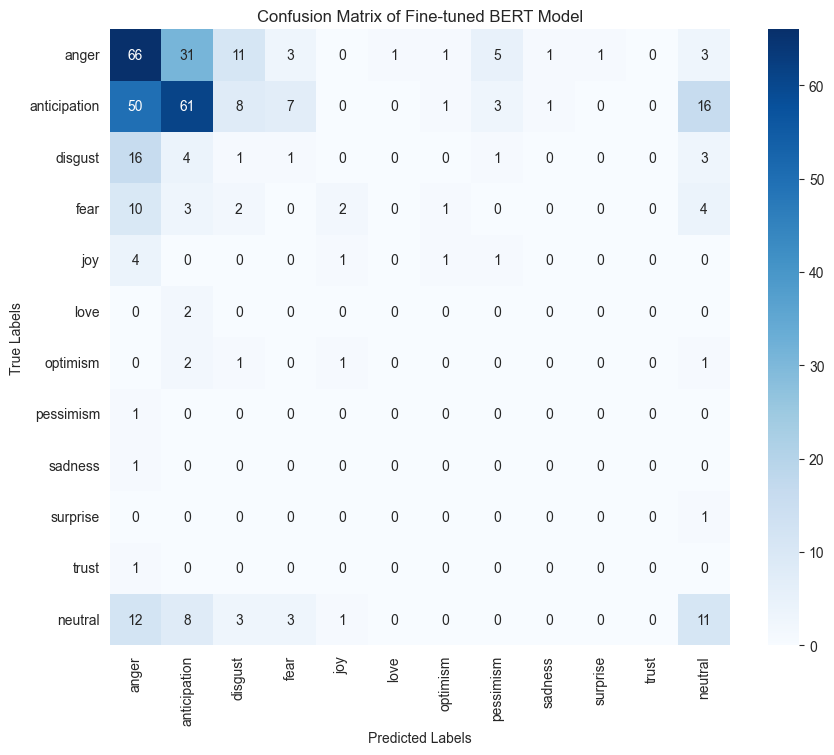

NameError: name 'history' is not defined

In [ ]:
# CELL 5: Đánh giá và vẽ biểu đồ
classifier_model.load_weights('model_small_bert.h5')
classifier_model.evaluate(input_data_test, label_data_test)
preds = classifier_model.predict(input_data_test)
preds = tf.round(preds).numpy()
print(classification_report(label_data_test, preds, target_names=label_class, zero_division = 0))

# Vẽ biểu đồ accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Vẽ biểu đồ loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
# CELL 6: Hàm dự đoán cảm xúc cho text mới
def predict_emotion(text):
    pred = classifier_model.predict([text], verbose=0)[0]
    results = {}
    for i, emotion in enumerate(label_class):
        if pred[i] >= 0.3:  # threshold
            results[emotion] = float(pred[i])
    return dict(sorted(results.items(), key=lambda x: x[1], reverse=True))

# Test thử
test_texts = [
    "I am absolutely thrilled about the results today!",
    "I am furious that this mistake happened; it’s completely unacceptable!",
    "I'm worried about what might happen tomorrow."
]

for text in test_texts:
    print(f"\nText: '{text}'")
    emotions = predict_emotion(text)
    print("Emotions:", emotions)


Text: 'I am absolutely thrilled about the results today!'
Emotions: {'sadness': 0.5391169190406799, 'fear': 0.5177218914031982, 'disgust': 0.5033428072929382, 'anticipation': 0.49995505809783936, 'surprise': 0.48562732338905334, 'anger': 0.4826614558696747, 'pessimism': 0.4462326467037201, 'joy': 0.4302424490451813, 'neutral': 0.42543983459472656, 'trust': 0.3889153301715851, 'love': 0.34110894799232483, 'optimism': 0.32455170154571533}

Text: 'I am furious that this mistake happened; it’s completely unacceptable!'
Emotions: {'sadness': 0.5487563610076904, 'disgust': 0.5212271213531494, 'anticipation': 0.5074817538261414, 'joy': 0.4996034801006317, 'surprise': 0.4857475757598877, 'fear': 0.4704210162162781, 'pessimism': 0.4692087173461914, 'anger': 0.4592687487602234, 'neutral': 0.40220388770103455, 'trust': 0.37643346190452576, 'love': 0.31858986616134644, 'optimism': 0.3067093789577484}

Text: 'I'm worried about what might happen tomorrow.'
Emotions: {'sadness': 0.540763795375824, '